Embedding Senses via Dictionary Bootstrapping
======================
This document outlines the pipeline needed to reproduce the results in the UAI paper "Embedding Senses via Dictionary Bootstrapping". We only present the minimally required code in order to keep everything as simple as possible. Also, some of the approaches have been slightly modified to illustrate how various techniques can be implemented. For example, the paper uses a sum of squared loss objective for training, while this tutorial uses a hinge loss. The differences are subtle, and you should feel free to test various models of your choice.

Prerequisite
-----------
Before we start, we require the following environmental setups.
* Python 2.7 or higher
* [Theano 0.9.0](http://deeplearning.net/software/theano/index.html)
 * In order to use your GPU, you should also set the `floatX` and `device` attributes in your `.theanorc` file
* [Matplotlib](https://matplotlib.org/)
* [scikit-learn](http://scikit-learn.org/stable/)
* CUDA installation (paths to `libcuda` and `nvcc` should be included in `LD_LIBRARY_PATH` and `PATH`, respectively)

Introduction
------------
First, we'll import a number of packages we need in order to build our model:

In [24]:
import theano
import theano.tensor as T
import numpy as np
import numpy.random as nr
import cPickle as pk
import os
import time

Please use the following links to download the data. The first link is to the main data file, and the second link is to
a collection of various pre-trained models, which we'll show how to use later.
* [Data](https://drive.google.com/open?id=0B7V13DJYRnxtdEY5dnc1QnREQUE) (Pickled, 724MB) 
* [Pre-trained model 1](https://drive.google.com/open?id=0B7V13DJYRnxtVGtqcGpReks4bTQ), [model 2](https://drive.google.com/open?id=0B7V13DJYRnxtTFZZOW12M0FqbEk), [model 3](https://drive.google.com/open?id=0B7V13DJYRnxtNUcweEZvNzBlRFk) (Pickled, 96MB each, trained with $\beta=0.3,0.4,0.5$)
* [Dictionary file](https://drive.google.com/open?id=0B7V13DJYRnxtUzVIZmRzSU5Edm8) (Text, 9.6MB)

You won't be needing the dictionary file for this session, since all necessary information have been encoded into the data file. We provide it just for your reference.  
After downloading the necessary files, modify the variables `data_in` and `saved_model` below to reflect the new location.  

In [6]:
data_in = './simple-data.pkl' # Path to input data. 
model_out = './models/'       # Path to save your model
save_name = 'my-save.pkl'     # Name of the file to save your model into
saved_model = 'model_example.pkl'       # Path to pre-existing trained model

Examining the data structure
----------------------------
Before we proceed with our model, let's take a look at the structure and encoding of the data. This may seem a bit tedious, but it's important for understanding the composition of the model we are about to build. If you're already familiar with the data format, or want to get straight to the point, feel free to skip this section (but the loading of the data is required to continue). 

We begin by loading the data file.

In [10]:
with open(data_in, 'rb') as f:
    d = pk.load(f)

The variable `d` is stored as a string->data hash table, whose keys are as follows:  
(PS: the correct term would be 'python dictionary', but we'll use 'hash table' in order to avoid confusion)
```
'def', 'def_plain', 'dmask', 'wmask', 'idf', 'dw2id', 'aw2id', 'id2dw', 'id2aw'
```
The main data is the accessed by the `def` key: The `i`-th entry into `d['def']` holds the definition encoding of the `i`-th word in the dictionary.  
Then how do we know which word is the `i`-th word? That's why we have a bunch of keys in the form of '(something)2(something)'.  
Here, '(something)' can be one of `aw`, `dw`, or `id`, where they stand for 'ambiguous word', 'disambiguous word', and 'id' (duh), respectively.  
* Ambiguous words are regular plain words we see every day: `apple`, `boat`, etc.   
* Disambiguous words are dictionary entries with their precise sense specified: `apple.n.01`, `boat.n.02`, etc.  
* Each (dis)ambiguous word is associated with a unique `id` that can be accessed by the appropriate '(something)2(something)' etnry.  

Thus, to get the encoding for the definition of `apple.n.01`, we can use the following piece of code:

In [43]:
word_id = d['dw2id']['apple.n.01']
print(d['def'][word_id])  # show the sense indices for each plain word in the definition (to be accessed by id2dw)
print(d['def_plain'][word_id]) # show the plain word indices in the definition (to be accessed by id2aw)

[[33785 33786 33787 ...,    -1    -1    -1]
 [81959 81960 81961 ...,    -1    -1    -1]
 [13759 63054 63055 ...,    -1    -1    -1]
 ..., 
 [   -1    -1    -1 ...,    -1    -1    -1]
 [   -1    -1    -1 ...,    -1    -1    -1]
 [   -1    -1    -1 ...,    -1    -1    -1]]
[1517   49   79   27  677   27 1602  585   42 3200    6 8837 8838  657 3103
   59   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1
   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1
   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1
   -1   -1   -1   -1   -1   -1   -1   -1]


As you can see, the encoding of the definition of `apple.n.01` takes a form of a 2D array, whose size is the maximum length of the definition times the maximum number of senses.  
Therefore, the total size of `d['def']` is `num_dw`-by-`num_max_def_len`-by-`num_max_sense`.   
If the definition is shorter than `num_max_def_len`, or each ambiguous word has fewer than the `num_max_sense`, the remaining positions will be filled with arbitrary placeholders (-1's, in this case).  
The binary mask variables exist to zero-out these placeholders. In particular, `d['dmask']` is used to mask out on the sense level, while `d['wmask']` is used on the word level. These variables will come in handy when we're building the model.

In [39]:
#num_dw, num_max_def_len, num_max_sense = d['def'].shape
assert(d['def'].shape == d['dmask'].shape)
print(d['dmask'].shape)
print(d['wmask'].shape)

(82831, 68, 25)
(82831, 68)


The non-negative entries that comprise `d['def']` are indexes into `d['id2dw']`.  
For example, let's look at all the possible senses of the third word in the definition of `apple.n.01`.

In [47]:
print(' '.join([d['id2aw'][x] for x in d['def_plain'][word_id] if x > 0])) # plain definition of apple.n.01

fruit with red or yellow or green skin and sweet to tart crisp whitish flesh <eos>


In [46]:
print([d['id2dw'][x] for x in d['def'][word_id][2] if x > 0]) # disambiguations of 'red'

['red.s.01', 'red.n.01', 'red.n.02', 'bolshevik.n.01', 'loss.n.06', 'crimson.s.02', 'crimson.s.03']


Building the model
------------------
Okay, now that you know how the dictionary is encoded, let's dive into the good part. The first step is to initialize the necessary variables and load them onto the GPU. In addition to the variable initialization, we also provide some helper functions that will become useful in the main code.

In [56]:
def shared_var(n, init_dat=None, shape=None, dtype='int32'):
    if init_dat is not None:
        value = init_dat
    elif shape is not None:
        value = nr.uniform(-0.1, 0.1, shape)
    else:
        return None
    return theano.shared(value.astype(dtype), name=n, borrow=True)

dtype = theano.config.floatX
bs = 64             # minibatch size
td = 300 # embedding dimension
hd = 600 # hidden dimension
nw, mw, ms = d['def'].shape # total number of words, max num. of words per definition, max num. of senses per word
params = {} # hash to hold the trainable parameters
tau = 10
# We need the following 3 lines to account for the discrepancy between 
# the true number of words (true_nw) vs. the number of words w/ IDs (nw). 
# This discrepancy exists because of some designs choices that have not been modified.
true_nw = nw
maxid = np.max(d['def'])
if maxid >= nw: nw = maxid + 1

#------------------- Shared variables ---------------------------------#
dat = shared_var('def', init_dat = d['def'])
#pd = shared_var('pd', init_dat = d['def_plain'])
dmask = shared_var('dmask', init_dat = d['dmask'], dtype=dtype)
wmask = shared_var('wmask', init_dat = d['wmask'], dtype=dtype)
sprior = shared_var('sprior', init_dat = np.ones(d['def'].shape), dtype=dtype) # uniform prior over senses
h_d = shared_var('idf', init_dat = d['idf'], dtype=dtype)
params['dwe'] = shared_var('dwe', shape = (nw, td), dtype = dtype) # disambiguated word embedding
params['L'] = shared_var('L', shape=(td, ), dtype=dtype) # diagonal entries only (of the td x td matrix)
params['L1'] = shared_var('L1', shape=(td, hd), dtype=dtype)
params['L2'] = shared_var('L2', shape = (hd, td), dtype = dtype)

## Helper function for saving the model
def save_model(save_dat, path):
    with open(path, 'wb') as f:
        pk.dump(save_dat, f, protocol=pk.HIGHEST_PROTOCOL)

Before we begin coding, recall how the embedding of each word $v_i$ is computed:
$$
v_i\gets(1-\beta)v_i+\beta\left(\sum_{d\in d(v_i)}h_d\sum_{v_j\in s(d)}\alpha_{ji}v_j\right)
$$
The paper refers to this update as a "message-passing RNN" or "fixed-point update". Since we don't explicitly deal with RNNs in the traditional sense, this tutorial will refer to it as the fixed-point update.  
Here, $d(v_i)$ is the set of all plain words that comprise the definition of $v_i$, and $s(d)$ is the set of all possible senses of a plain word $d$. The update equation states that the new embedding of $v_i$ is computed as a doubly-convex combination of the words that constitute its definition. The hyper-parameter $\beta\in(0,1)$ is gradually decreased over training iteration in order to ensure convergence.  
The coefficients $h_d$'s are constants set to the inverse document frequency (IDF) of the plain word $d$. These values are pre-computed into the theano variable `idf`.  
The second set of coefficients $\alpha$ are computed as $\alpha_{ji}\propto\Pr(v_j)\Pr(d_{-i}|v_j)$,
where $d_{-i}$ denotes the list of plain words in the definition *except* the `i`-th word; i.e., the context of $d_i$. 
The values of the prior $\Pr(v_j)$ is stored in the theano variable `sprior`, while the likelihood of the context will take another trainable form.
$$
\Pr(d_{-i}|v_j)=\prod_{d_m\in d_{-i}}\Pr(d_m|v_j)\propto\prod_{d_m\in d_{-i}}\exp\left(\frac{\tau}{\left\vert s(d_m)\right\vert}\sum_{v_k\in s(d_m)}v_j^TUv_k\right)
$$
The parameter $U=LL$ is a trainable positive-definite matrix represented by the theano variable `L`, and $\tau$ is a hyper-parameter that specifies the 'temperature' of the softmax distribution. Note that the term $v_j^TUv_k$ can be replaced by any function that returns the similarity between $v_j$ and $v_k$.

First, we'll write a helper function we call to compute the coefficients $\alpha_{ji}$'s. This function `to_weight()` returns the $\alpha$ coefficient for a single dictionary entry. Since we wish to proceed the training in minibatches, the $\alpha$ computation should be carried over multiple instances. To do this, we `scan()` through the minibatch to collect the results. Note that it is possible to perform this operation purely via matrix operations (as opposed to looping), but that usually requires too much memory and time.

In [57]:
dwe = params['dwe'] # nw x td
L = params['L']     # td
L1 = params['L1']   # td x hd
L2 = params['L2']   # hd x td

wi = T.ivector('wi') # bs
df = dat[wi, :]      # bs x mw x ms
pr = sprior[wi, :]   # bs x mw x ms
dm = dmask[wi, :]    # bs x mw x ms
wm = wmask[wi, :].dimshuffle(0, 1, 'x') # bs x mw x 1
lr = T.dscalar('lr')
idf = h_d[wi].dimshuffle(0, 1, 'x') # bs x mw x 1

'''
Returns: alpha coefficients of size mw x ms. 
d: indices of the senses that comprise the definition (mw x ms)
m: mask of size mw x ms
prior: Pr(v_j) for each v_j in each plain word in the definition (mw x ms)
'''
def to_weight(d, m, prior):
    half_dot = dwe[d, :] * L.dimshuffle('x', 'x', 0) # mw x ms x td
    logit = T.tensordot(half_dot, half_dot.T, axes=1) # mw x ms x ms x mw
    logit = logit.dimshuffle(0, 1, 3, 2) # mw x ms x mw x ms
    cnt = T.sum(m, axis=1).dimshuffle('x', 'x', 0) # 1 x 1 x mw
    logit = T.sum(logit * m.dimshuffle('x', 'x', 0, 1), axis=3) / cnt # mw x ms x mw
    logit = T.exp(tau * T.switch(T.isnan(logit), 0, logit)) # mw x ms x mw
    logit = T.prod(logit, axis=2) * prior # mw x ms
    sm = T.sum(logit * m, axis=1, keepdims=True) # mw x 1
    logit = (logit * m) / sm # mw x ms
    return T.switch(T.or_(T.isnan(logit), T.isinf(logit)), 0, logit)

alphas, _ = theano.scan(fn = to_weight, sequences = [df, dm, pr])
raw_emb = T.sum(alphas.dimshuffle(0, 1, 2, 'x') * dwe[df, :], axis = 2) # bs x mw x td
e_i = T.sum((raw_emb.astype(dtype) * idf) * wm, axis = 1) # bs x td (the doubly-convex combination of senses and plain words)
new_emb = T.tanh(T.dot(e_i, L1)) # bs x hd
new_emb = T.dot(new_emb, L2) # bs x td, after passing through a 2-layer network

The final computation of `new_emb` is done by summing up the sense-level embeddings, and passing through a two-layer network.
$$
f_{\Theta}(e_i)=L_2^T\tanh(L_1^Te_i), ~~~\Theta\triangleq\{L, L_1, L_2\}
$$
Next, we need a training signal to adjust the parameters $\Theta$. The training criterion we use is how close $f_\Theta(e_i)$ (i.e., `new_emb`) is to the current vector $u_i$ (i.e., `dwe[wi, :]`). Our paper suggested an L2 regression approach, but here we'll try a hinge loss approach. The hinge loss takes both a positive sample ($u_i$) and a negative sample ($n_i$) and attempts to widen the gap between the two. The negative sample $n_i$ is an embedding of a randomly sampled word not equal to $u_i$.
$$
\min_\Theta\frac{1}{N}\sum_i^N\max\{0,m-cosim(f_\Theta(e_i),u_i)+cosim(f_\Theta(e_i),n_i)\}
$$
In words, we are maximizing the average cosine similarities between the positive samples while minimizing the similarities between the negative samples. The differences are mitigated by the margin parameter `m`, which we set to 0.01.

We optimize the above objective using a simple stochastic gradient descent (SGD) procedure. Applying more sophisticated optimization algorithms such as Adam, AdaGrad, and RMSProp is straightforward since they are readily available in most DL libraries. Here, we wish to demonstrate the simplest form to show the feasibility of our approach.  

In [58]:
nwi = T.ivector('nwi') # indices of negative samples
beta = T.dscalar('beta')
ndw = dwe[nwi, :] # bs x td
pdw = dwe[wi, :]  # bs x td
def cosim(x, y):
    return T.mean(T.sum(x * y, axis=1) / (x.norm(2, axis=1) * y.norm(2, axis=1)))

pos_cost = -cosim(new_emb, pdw) #T.mean(T.sum((new_emb - pdw) ** 2, axis=1)) #
neg_cost = -cosim(new_emb, ndw) #T.mean(T.sum((new_emb - ndw) ** 2, axis=1))
tot_cost = T.mean(T.maximum(0, 0.01 + pos_cost - neg_cost))
## Uncomment the following if you wish to add regularization
# tot_cost += 0.1 * T.sum(abs(L1)) + 0.1 * T.sum(abs(L2))
all_params = [params['L'], params['L1'], params['L2']] # list of parameters we wish to optimize via SGD

## Now we build the SGD-based update
grads = T.grad(tot_cost, all_params)
updates = [] # updates for the embedding parameters to be used by SGD
for (p, g) in zip(all_params, grads):
    updates.append((p, p - lr * g))

## Next we construct the fixed-point update (or as the paper says, the "message-passing update")
#fp_term = T.sum(raw_emb * idf.dimshuffle(0, 1, 'x'), axis = 1) # bs x td
fp_emb = (1 - beta) * pdw + beta * e_i
fp_update = T.set_subtensor(pdw, fp_emb.astype(dtype))
dwe_update = [(dwe, fp_update)] # we wish to update only a portion of dwe
dwe_diff = T.max(T.abs_(fp_emb - pdw)) # maximum increment

train_step = theano.function([wi, nwi, lr], tot_cost, updates = updates) # \Theta trainer
dwe_update_step = theano.function([wi, nwi, beta], [tot_cost, dwe_diff, new_emb], updates = dwe_update)  # fixed-point iterator

One interesting thing to note here, is that the parameters $L_1, L_2$ are *not* used to compute the actual embedding of $v_i$. Rather, they seem to act as providing the value of $L$ with a rough guidance signal so that $L$ has a better chance of finding good values. This was not intended in design time, as we started off with the following update equation:
> fp_emb = (1 - beta) * pdw + beta * new_emb  

But that ended up giving not-so-good results. We then substituted `new_emb` with `e_i`, which depends only on $L$, and began getting reasonable embeddings. Feel free to use the above original equation and let us know if you find something interesting (maybe we made a mistake).

Training the model
--------------------
Once we have the necessary theano functions compiled, we are ready to code the main process that will drive the overall training. The basic idea is to alternate between training the $L, L_1, L_2$ parameters via SGD and updating the actual embedding via the fixed-point iteration.
We will perform multiple iterations of SGD followed by a single iteration of fixed-point updates. The number of SGD iterations can be adjusted by setting the value of `num_consec_train`.

In [61]:
## Begin training code
print('Training...')
indexes = range(true_nw)
num_epoch = 10       # total number of epochs to train
cur_ep = 0
cur_lr = 5e-2
num_consec_train = 5 # number of consecutive epochs for 'sgd'
mode = ['sgd', 'fp']
cur_mode = 1 # start with 'fp'. Set this to 0 if you want to start with SGD
tol = 1e-3
next_schedule = 5
dwe_up_cnt = 0
beta = 0.7
tic = 100

while cur_ep < num_epoch:
    nr.shuffle(indexes)
    neg_ind = indexes[bs:] + indexes[:bs]
    cost = 0
    totTime = 0
    max_diff = -np.inf
    cur_beta = beta ** (dwe_up_cnt + 1)
    for cur_iter in np.arange(0, nw, bs):
        cur_ind = indexes[cur_iter : min(cur_iter + bs, true_nw - 1)]
        cur_neg_ind = neg_ind[cur_iter : min(cur_iter + bs, true_nw - 1)]
        st = time.time()
        if cur_mode == 0: # performing SGD
            tc = train_step(cur_ind, cur_neg_ind, cur_lr)
        else:            # performing fixed-point iteration
            ret = dwe_update_step(cur_ind, cur_neg_ind, cur_beta)
            tc, diff = ret[0], ret[1]
            max_diff = max(max_diff, float(diff))
            dwe_up_cnt += 1
        et = time.time()
        totTime += (et - st)
        cost += tc
        if (cur_iter // bs) % tic == 0: # print the *CUMULATIVE* cost
            print('[{0}] {1}, cumul. cost = {2:.3f}, max_diff = {3:.3f} ({4:.1f} sec.)'.format(\
                mode[cur_mode], cur_iter // bs, cost, max_diff, totTime))
            totTime = 0
    if cur_mode == 1 and max_diff < tol:
        cur_mode = 0  # switch to SGD
        max_diff = -np.inf
        next_schedule = cur_ep + num_consec_train
    elif cur_mode == 0 and next_schedule == cur_ep:
        cur_mode = 1 # switch to fixed-point iteration
        dwe_up_cnt = 0
        
    print('\t*** Epoch {}, cost = {} ***'.format(cur_ep, cost))
    save_model(params, os.path.join(model_out, save_name))
    cur_ep += 1

Training...
[fp] 0, cumul. cost = 0.011, max_diff = 0.032 (1.7 sec.)
[fp] 100, cumul. cost = 1.142, max_diff = 0.051 (174.1 sec.)
[fp] 200, cumul. cost = 2.073, max_diff = 0.059 (176.2 sec.)
[fp] 300, cumul. cost = 3.233, max_diff = 0.073 (171.0 sec.)
[fp] 400, cumul. cost = 4.250, max_diff = 0.073 (171.4 sec.)
[fp] 500, cumul. cost = 5.418, max_diff = 0.073 (174.1 sec.)
[fp] 600, cumul. cost = 6.378, max_diff = 0.073 (180.6 sec.)
[fp] 700, cumul. cost = 7.331, max_diff = 0.073 (183.1 sec.)
[fp] 800, cumul. cost = 8.351, max_diff = 0.073 (184.6 sec.)
[fp] 900, cumul. cost = 9.446, max_diff = 0.073 (184.0 sec.)
[fp] 1000, cumul. cost = 10.373, max_diff = 0.073 (178.1 sec.)
[fp] 1100, cumul. cost = 11.387, max_diff = 0.073 (176.8 sec.)
[fp] 1200, cumul. cost = 12.475, max_diff = 0.073 (175.7 sec.)
	*** Epoch 0, cost = 13.5557944103 ***
[fp] 0, cumul. cost = 0.023, max_diff = 0.000 (1.7 sec.)
[fp] 100, cumul. cost = 1.163, max_diff = 0.000 (178.2 sec.)
[fp] 200, cumul. cost = 2.300, max_d

KeyboardInterrupt: 

We had to interrupt the training process since it takes several hours before it converges, but you can see that the per-epoch cumulative costs show a decreasing trend.  
In the next section, we show how to load this saved model file in order to use the learned embeddings. Of course, we'll use one of the pre-trained models.

Running the model
-------------------
Next, we'll show you how to *use* the trained model. Since training the above model can take up to several days, we have provided a pre-trained embedding. If you've followed the instructions in the introduction, the path to the pre-trained model file will be stored in variable `saved_model`.

The first example we show is a simple nearest neighbor retrieval. For each sample words, we retrieve three of its nearest neighbors to see how close in semantics they are. There can be many notions of "nearest", but we again use the cosine similarity measure.

In [62]:
def sim(x, y):
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

with open(saved_model, 'rb') as f:
    m = pk.load(f)
wd_emb = m['dwe'].get_value() # need to "download" the data back to CPU
d2i = d['dw2id']
i2d = d['id2dw']
ind = [d2i['bank.n.01'], d2i['bank.n.05'], d2i['paper.n.01'], d2i['paper.n.05'], d2i['apple.n.01'], d2i['boat.n.01']]

for wi in ind:
    lst = []
    for (wd, _) in enumerate(wd_emb):
        if wi == wd: continue
        s = sim(wd_emb[wi], wd_emb[wd])
        lst.append((s, i2d[wd]))
    lst.sort(key = lambda e: e[0], reverse = True) # soft with descending similarity
    nn_w = lst[0:3]
    print(i2d[wi] + '\t' + str(nn_w))
    

bank.n.01	[(0.38072157, 'sloping.s.02'), (0.30345541, 'acclivitous.s.01'), (0.29497349, 'slop.v.03')]
bank.n.05	[(0.47069725, 'store.n.02'), (0.46000367, 'forehanded.s.02'), (0.45024586, 'hereafter.r.02')]
paper.n.01	[(0.47097549, 'cellulose.n.01'), (0.44648162, 'cellulosic.n.01'), (0.41017959, 'cellulose_xanthate.n.01')]
paper.n.05	[(0.54464161, 'scholarly.a.01'), (0.53724164, 'unscholarly.a.01'), (0.53698415, 'tome.n.01')]
apple.n.01	[(0.56428581, 'cortland.n.01'), (0.53956342, 'winesap.n.01'), (0.50557792, 'delicious.n.01')]
boat.n.01	[(0.42228055, 'regatta.n.01'), (0.42193556, 'mailboat.n.01'), (0.40844288, 'vessel.n.03')]


Some of the results include apparent false-positives, such as `slop.v.03`. This is because our approach depends largely on the quality of the definitions provided by the dictionary. That is, the richer the description for the word is, the more accurate the embeddings will be. Our setting used a simple WordNet dictionary, which provides short-length definitions that could potentially cause more ambiguities. Nevertheless, some of the nearest neighbors well-reflect the true semantics of the target word. Perhaps you could find a better dataset to train on, in order to refine our results.

Next, we'll see how to plot some of the select vectors onto the 2D plane. The dimensionality reduction technique that downsizes the 300 dimensional word vectors is t-SNE. The Python package `scikit-learn` provides a good implementation, so we'll use that. To see different testing settings, try uncommenting one of lines 4~6.

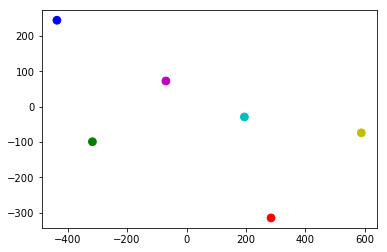

In [18]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# words = ['male.n.01', 'king.n.01', 'son.n.01', 'daughter.n.01', 'female.n.01', 'queen.n.02'] # male-female relationship
# words = ['drink.n.03', 'drink.v.01', 'eat.v.01', 'magma.n.01', 'rock.n.01', 'food.n.01'] # liquid-solid relationship
words = ['man.n.01', 'woman.n.01', 'fireman.n.04', 'housewife.n.01', 'dressmaker.n.01', 'policeman.n.01'] # gender inequality plot
tsne = TSNE(n_components = 2, init = 'pca', method = 'exact')
X = np.array([wd_emb[d2i[x]] for x in words])
Y = tsne.fit_transform(X)

plt.scatter(Y[:, 0], Y[:, 1], s = 60, c = ['r', 'g', 'b', 'y', 'c', 'm', 'k', 'w'])
plt.show()